In [3]:
!pip install gensim

  Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)


In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer

from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
# from gensim.models import FastText

In [2]:
embeddings = pd.read_pickle("./data/clean_2020articles_w_title_embeddings.pkl")

In [4]:
# embeddings

In [3]:
train, test = train_test_split(embeddings, test_size=0.4, random_state=42)

In [27]:
corpus = train.loc[:, 'title']
#corpus

4594     south dakota governor: election a ‘choice’ bet...
10698    ilhan omar: many who want to ‘prematurely reop...
19212    perdue: ‘who would believe that you could spen...
28302              nancy pelosi: everything we’re doing...
36418    georgia's republican u.s. senators call on gop...
                               ...                        
16850    joe biden sought ‘grand bargain’ to reduce def...
6265     world health organization: abortion is ‘essent...
11284    dick cheney’s former cardiologist: trump has 1...
860      matt gaetz: if swalwell can say his sex life i...
15795    watch: hecklers during live shot shout ‘cnn is...
Name: title, Length: 3704, dtype: object

In [28]:
# cv = CountVectorizer(ngram_range=(1, 2), min_df=0.001, max_df=0.99)
# cv_matrix = cv.fit_transform(corpus)
# cv_matrix.shape

In [29]:
# tokenizing title docs
tokenized_docs = [doc.split() for doc in corpus]
ft_model = FastText(tokenized_docs, vector_size=512, window=20, min_count=2, 
                    workers=1, sg=1, seed=42, epochs=10)

In [30]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)

    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.

        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

In [11]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 512)
doc_vecs_ft.shape


(37, 512)

In [12]:
# doc_vecs_ft[0]

In [5]:
train["bert_embeddings"] = train["bert_sentence_embedding_title_only"].apply(lambda x: x.cpu())
train["np_embeddings"] = train["bert_embeddings"].apply(lambda x: x.numpy())
np_embedding = np.vstack(train["np_embeddings"])

In [6]:
np_embedding.shape[0]

22226

In [7]:
def ward_hierarchical_clustering(feature_matrix):
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_hierarchical_clusters(linkage_matrix, data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    titles = data['title'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left",
                   truncate_mode='lastp',
                   p=p,
                   no_plot=True)
    temp = {R["leaves"][ii]: titles[ii] for ii in range(len(R["leaves"]))}

    def llf(xx):
        return "{}".format(temp[xx])

    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,
            leaf_label_func=llf,
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig(f'./data/bert_hierachical_clusters_num_docs_{data.shape[0]}_level_{p}.png', dpi=200)

In [9]:
bert_linkage_matrix = ward_hierarchical_clustering(np_embedding)

In [ ]:
fast_text_linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

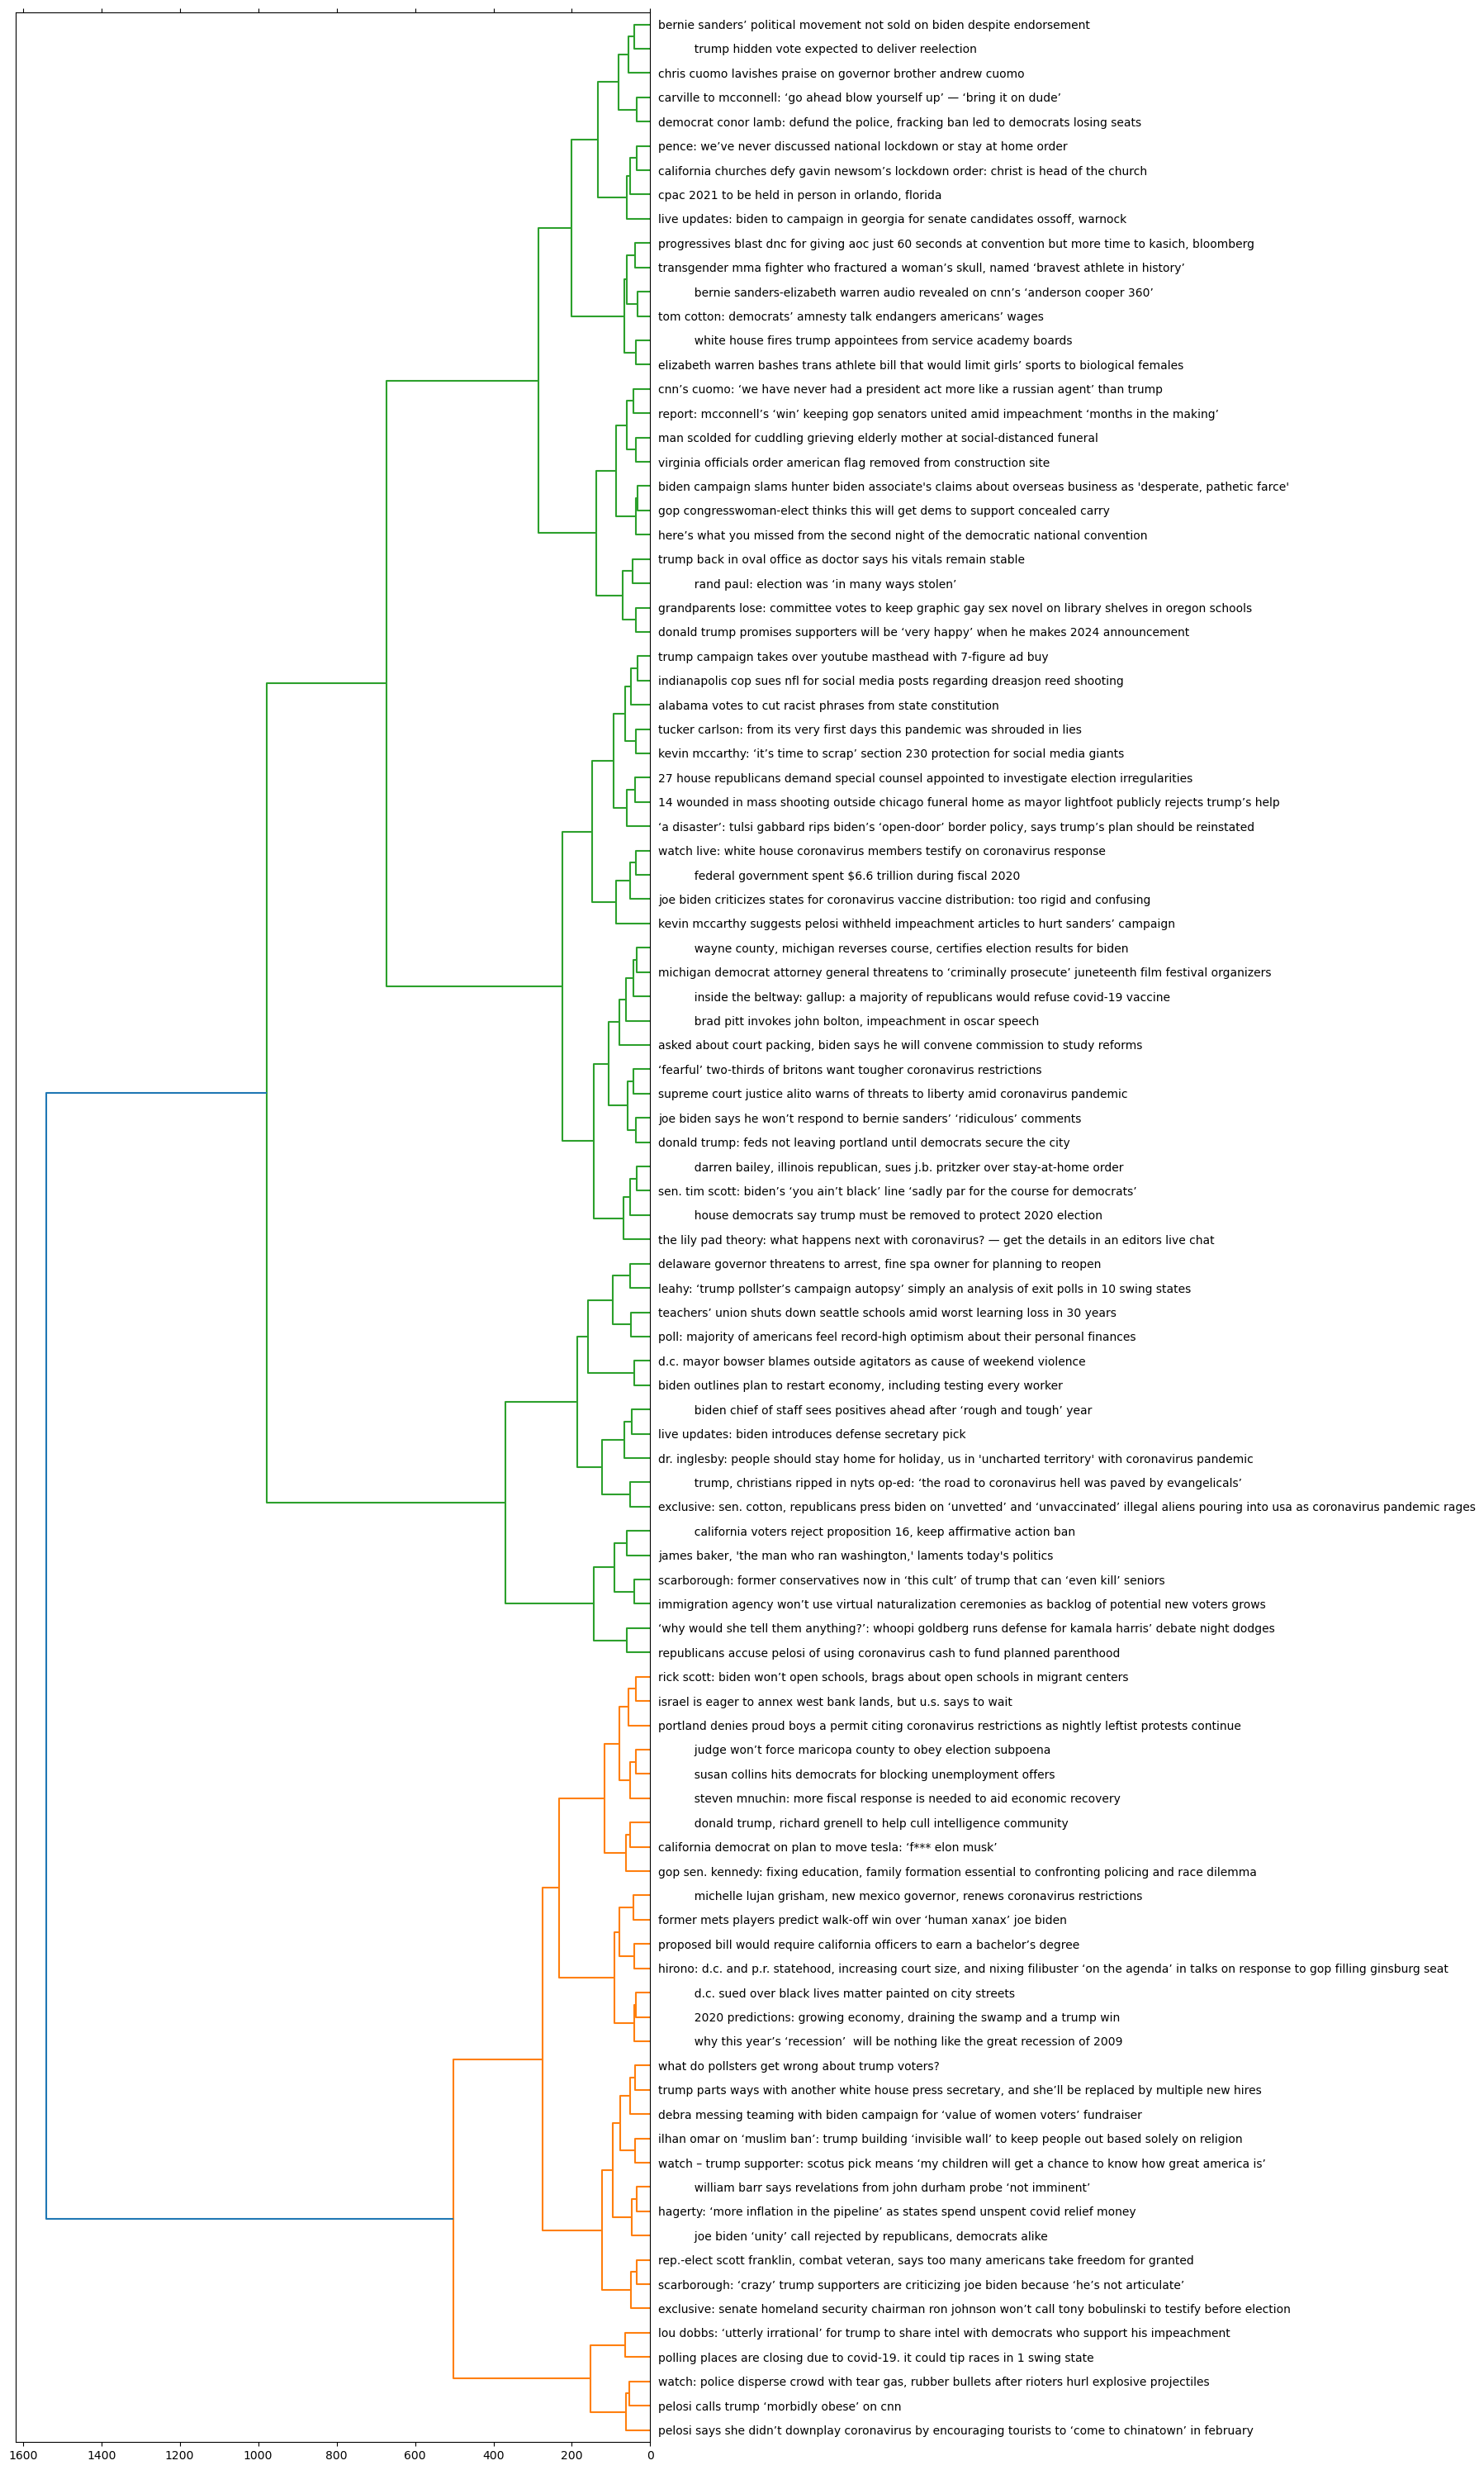

In [98]:
plot_hierarchical_clusters(bert_linkage_matrix,
                           p=100,
                           data=train,
                           figure_size=(18, 30))

KeyboardInterrupt: 

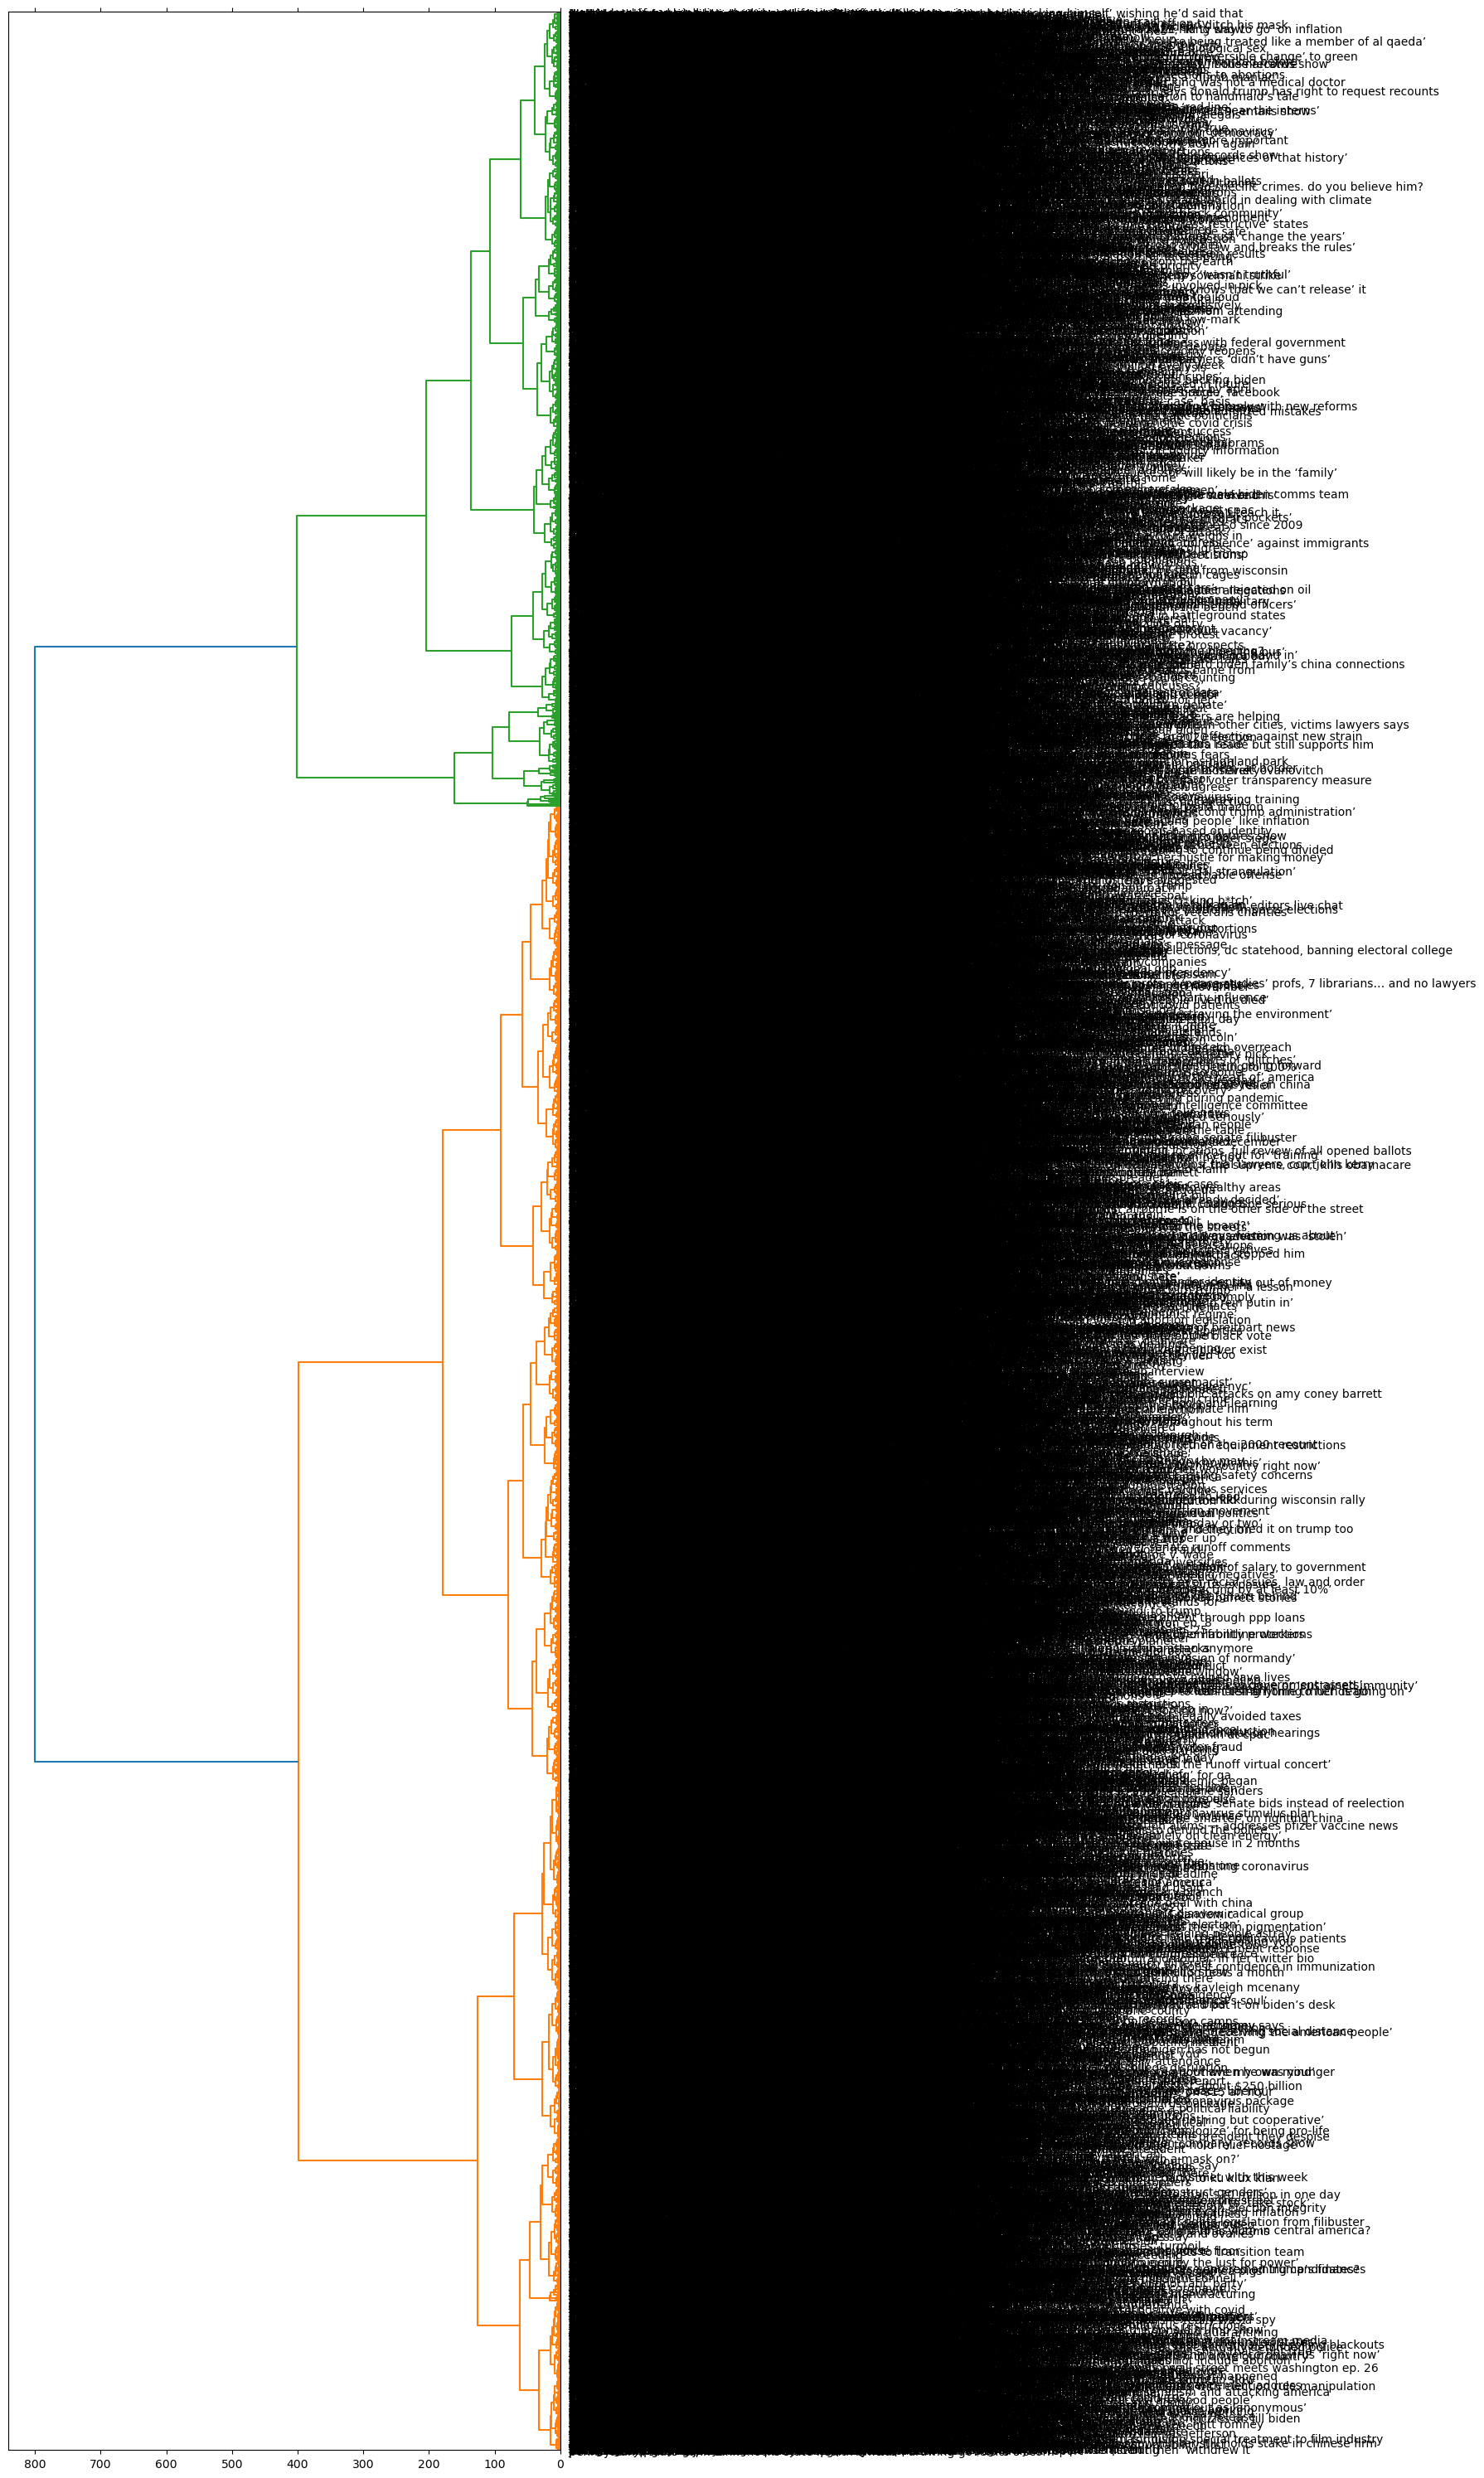

In [77]:
plot_hierarchical_clusters(bert_linkage_matrix,
                           p=100,
                           data=train,
                           figure_size=(18, 30))

In [13]:
# This actually assigns a cluster number to each item depending on a certain cutoff point
# using a distance of 15 would give us 27 clusters!!
fcluster(bert_linkage_matrix, 20, criterion='distance').max()

233

In [12]:
fcluster(bert_linkage_matrix, 0.3, criterion='distance')

array([ 1701,  1663, 19423, ..., 12209,  7661,  7582], dtype=int32)

In [ ]:
# TODO map cluster numbers back to articles in training set and doo topic analysis

## Topic Analysis on BERT clusters

In [5]:
bert_linkage_matrix = np.load('data/bert_22kdocs_bert_embedding_linkage_matrix.npy') 

In [20]:
train = pd.read_csv('data/bert_22kdocs_cluster_assignments.csv', index_col=0)

In [29]:
train_embed_df = pd.read_pickle('data/clean_2020articles_w_title_embeddings.pkl')

In [30]:
train_embed_df.head(5)

,uuid,source,year,article_text,title,title_text,bert_sentence_embedding_title_only
0,bcbc6bb2-406e-11ee-a96e-33dec8f414a2,wp,2020,president trump on monday said he was “proud” ...,"trump shifts tone, says he’s ‘proud’ of fed am...","trump shifts tone, says he’s ‘proud’ of fed am...","[tensor(-0.0145, device='cuda:0'), tensor(0.29..."
1,cfb4ce29-406e-11ee-a96e-33dec8f414a2,wp,2020,u.s. intelligence reportedly indicates iran’s ...,"iran paid bounties for targeting us troops, in...","iran paid bounties for targeting us troops, in...","[tensor(-0.8398, device='cuda:0'), tensor(-0.0..."
2,db9f408f-406e-11ee-a96e-33dec8f414a2,wp,2020,u.s. forces have rescued an american citizen h...,us forces rescue american citizen held hostage...,us forces rescue american citizen held hostage...,"[tensor(-0.5563, device='cuda:0'), tensor(0.20..."
3,e7b340f7-406e-11ee-a96e-33dec8f414a2,thehill,2020,president trump on tuesday evening blasted con...,"trump slams relief bill, calls on congress to ...","trump slams relief bill, calls on congress to ...","[tensor(-0.9571, device='cuda:0'), tensor(-0.2..."
4,a43934fc-411f-11ee-a96e-33dec8f414a2,thehill,2020,japanese tennis star naomi osaka has withdrawn...,naomi osaka withdraws from french open to focu...,naomi osaka withdraws from french open to focu...,"[tensor(-0.6783, device='cuda:0'), tensor(-0.1..."


In [6]:
bert_linkage_matrix.shape

(22225, 4)

In [122]:
bert_linkage_matrix[:, 2].max()


1541.1058720666347

In [31]:
train_embed_df = pd.merge(train, train_embed_df, how='inner', on='uuid')

In [33]:
train_embed_df = train_embed_df.loc[:,['uuid','bert_sentence_embedding_title_only']]

In [38]:
train_embed_df["bert_embeddings"] = train_embed_df["bert_sentence_embedding_title_only"].apply(lambda x: x.cpu())
train_embed_df["np_embeddings"] = train_embed_df["bert_embeddings"].apply(lambda x: x.numpy())
train_np_embedding = np.vstack(train_embed_df["np_embeddings"])

In [13]:
backup = train.copy()
backup.head()

,uuid,source,year,article_text,title,title_text
6025,c6f115b2-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,house speaker nancy pelosi dismissed the idea ...,pelosi says she didn’t downplay coronavirus by...,pelosi says she didn’t downplay coronavirus by...
5418,95cae34e-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,speaker of the house nancy pelosi called presi...,pelosi calls trump ‘morbidly obese’ on cnn,pelosi calls trump ‘morbidly obese’ on cnn spe...
14686,b2f2b844-411f-11ee-a96e-33dec8f414a2,breitbart,2020,kenosha police units determined to enforce the...,"watch: police disperse crowd with tear gas, ru...","watch: police disperse crowd with tear gas, ru..."
35332,c8b20d44-4136-11ee-a96e-33dec8f414a2,npr,2020,"fromby \n \n kate payne\n \n , ...",polling places are closing due to covid-19. it...,polling places are closing due to covid-19. it...
23999,7d814407-3da8-11ee-a96e-33dec8f414a2,dailycaller,2020,fox business network host lou dobbs argued fri...,lou dobbs: ‘utterly irrational’ for trump to s...,lou dobbs: ‘utterly irrational’ for trump to s...


In [40]:
# np.save('./data/bert_22kdocs_bert_embedding_linkage_matrix.npy', bert_linkage_matrix)

In [14]:
train_df = train.copy()
# train_df = train_df.drop(['bert_sentence_embedding_title_only', 'bert_embeddings', 'np_embeddings', 'cluster_id'], axis=1)
train_df.head()

,uuid,source,year,article_text,title,title_text
6025,c6f115b2-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,house speaker nancy pelosi dismissed the idea ...,pelosi says she didn’t downplay coronavirus by...,pelosi says she didn’t downplay coronavirus by...
5418,95cae34e-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,speaker of the house nancy pelosi called presi...,pelosi calls trump ‘morbidly obese’ on cnn,pelosi calls trump ‘morbidly obese’ on cnn spe...
14686,b2f2b844-411f-11ee-a96e-33dec8f414a2,breitbart,2020,kenosha police units determined to enforce the...,"watch: police disperse crowd with tear gas, ru...","watch: police disperse crowd with tear gas, ru..."
35332,c8b20d44-4136-11ee-a96e-33dec8f414a2,npr,2020,"fromby \n \n kate payne\n \n , ...",polling places are closing due to covid-19. it...,polling places are closing due to covid-19. it...
23999,7d814407-3da8-11ee-a96e-33dec8f414a2,dailycaller,2020,fox business network host lou dobbs argued fri...,lou dobbs: ‘utterly irrational’ for trump to s...,lou dobbs: ‘utterly irrational’ for trump to s...


In [47]:
# train_df.to_csv('./data/bert_22kdocs_bert_embedding_linkage_matrix_matching_training_df.csv') 

In [50]:
# test_train_df = pd.read_csv('./data/bert_22kdocs_bert_embedding_linkage_matrix_matching_training_df.csv', index_col=0)
# test_train_df.head()

,uuid,source,year,article_text,title,title_text
6025,c6f115b2-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,house speaker nancy pelosi dismissed the idea ...,pelosi says she didn’t downplay coronavirus by...,pelosi says she didn’t downplay coronavirus by...
5418,95cae34e-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,speaker of the house nancy pelosi called presi...,pelosi calls trump ‘morbidly obese’ on cnn,pelosi calls trump ‘morbidly obese’ on cnn spe...
14686,b2f2b844-411f-11ee-a96e-33dec8f414a2,breitbart,2020,kenosha police units determined to enforce the...,"watch: police disperse crowd with tear gas, ru...","watch: police disperse crowd with tear gas, ru..."
35332,c8b20d44-4136-11ee-a96e-33dec8f414a2,npr,2020,"fromby \n \n kate payne\n \n , ...",polling places are closing due to covid-19. it...,polling places are closing due to covid-19. it...
23999,7d814407-3da8-11ee-a96e-33dec8f414a2,dailycaller,2020,fox business network host lou dobbs argued fri...,lou dobbs: ‘utterly irrational’ for trump to s...,lou dobbs: ‘utterly irrational’ for trump to s...


In [51]:
# Extracting cluster information
# clusters = {}
# for i, merge in enumerate(bert_linkage_matrix):
#     cluster_id = i + len(train)  # Cluster IDs start from len(X) and increment
#     left_child = int(merge[0])
#     right_child = int(merge[1])
#     distance = merge[2]
#     clusters[cluster_id] = {'left': left_child, 'right': right_child, 'distance': distance}

# for cluster_id, info in clusters.items():
#     left_row = train.iloc[info['left']]
#     right_row = train.iloc[info['right']]
#     print(f"Cluster {cluster_id}: Left Row - {left_row}, Right Row - {right_row}")

In [87]:
train_cluster_assignments = train.copy()
# train_cluster_assignments = train_cluster_assignments.drop(['bert_sentence_embedding_title_only', 'bert_embeddings', 'np_embeddings'], axis=1)
distance_options = [0.5, 1, 2, 3, 4, 5, 10, 20, 50, 100, 150, 200, 300, 500, 1000]
for opt in distance_options:
    cluster_assignment = fcluster(bert_linkage_matrix, opt, criterion='distance')
    print(f'dist: {opt} num_clusters: {cluster_assignment.max()}')
    train_cluster_assignments[f'cluster_dist_{opt}'] = cluster_assignment
    

dist: 0.5 num_clusters: 21996
dist: 1 num_clusters: 21808
dist: 2 num_clusters: 18175
dist: 3 num_clusters: 10329
dist: 4 num_clusters: 5559
dist: 5 num_clusters: 3435
dist: 10 num_clusters: 829
dist: 20 num_clusters: 233
dist: 50 num_clusters: 62
dist: 100 num_clusters: 23
dist: 150 num_clusters: 14
dist: 200 num_clusters: 11
dist: 300 num_clusters: 6
dist: 500 num_clusters: 5
dist: 1000 num_clusters: 2


In [88]:
def compute_silhouette(orig_data, linkage_matrix, distance):
    labels = fcluster(linkage_matrix, distance, criterion='distance')
    silhouette_avg = silhouette_score(orig_data, labels)
    return silhouette_avg

sil_scores = []
for opt in distance_options:
    sil_score = compute_silhouette(train_np_embedding, bert_linkage_matrix, opt)
    sil_scores.append(sil_score)

# Print silhouette scores for different distance cutoffs
for cutoff, score in zip(distance_options, sil_scores):
    print(f"Distance cutoff: {cutoff}, Silhouette Score: {score}")

Distance cutoff: 0.5, Silhouette Score: 0.01993325538933277
Distance cutoff: 1, Silhouette Score: 0.019511986523866653
Distance cutoff: 2, Silhouette Score: 0.007878360338509083
Distance cutoff: 3, Silhouette Score: -0.026958566159009933
Distance cutoff: 4, Silhouette Score: -0.04218493774533272
Distance cutoff: 5, Silhouette Score: -0.04913640767335892
Distance cutoff: 10, Silhouette Score: -0.05375361070036888
Distance cutoff: 20, Silhouette Score: -0.055287767201662064
Distance cutoff: 50, Silhouette Score: -0.04986659437417984
Distance cutoff: 100, Silhouette Score: -0.042364347726106644
Distance cutoff: 150, Silhouette Score: -0.04147468879818916
Distance cutoff: 200, Silhouette Score: -0.01381657924503088
Distance cutoff: 300, Silhouette Score: 0.012360634282231331
Distance cutoff: 500, Silhouette Score: 0.011448411270976067
Distance cutoff: 1000, Silhouette Score: 0.13664643466472626


In [61]:
# train_cluster_assignments.to_csv('./data/bert_22kdocs_cluster_assignments.csv') 

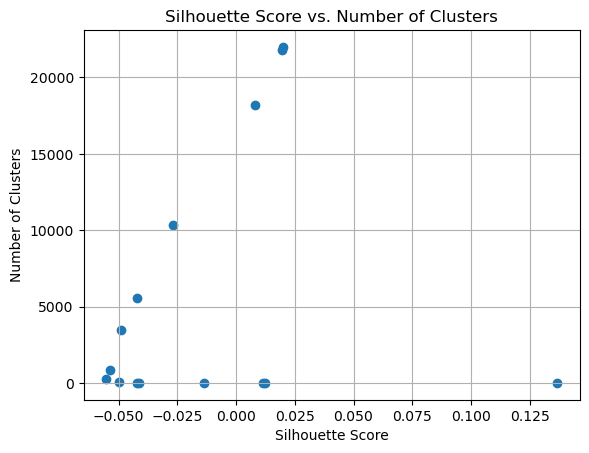

In [99]:
num_clusters = [21996, 21808, 18175, 10329, 5559, 3435, 829, 233, 62, 23, 14, 11, 6, 5, 2]
plt.scatter(sil_scores, num_clusters, marker='o')
plt.xlabel('Silhouette Score')
plt.ylabel('Number of Clusters')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

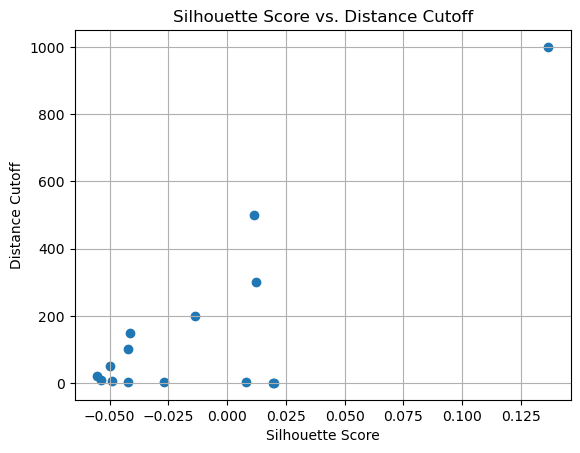

In [100]:
plt.scatter(sil_scores, distance_options, marker='o')
plt.xlabel('Silhouette Score')
plt.ylabel('Distance Cutoff')
plt.title('Silhouette Score vs. Distance Cutoff')
plt.grid(True)
plt.show()

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [43]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

In [46]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words))

In [108]:
tfidf_scores_by_cluster = {}
cluster_sizes = {}
for clust_id in list(train_cluster_assignments.loc[:, 'cluster_dist_2'].unique()):
    clust_df = train_cluster_assignments.loc[train_cluster_assignments.loc[:, 'cluster_dist_2'] == clust_id, :]
    cluster_sizes[clust_id] = clust_df.shape[0]
    clust_text = clust_df.loc[:, 'title'].values
    tfidf_matrix = tfidf_vectorizer.fit_transform(clust_text)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0)
    tfidf_scores_by_cluster[clust_id] = [(feature_names[col], tfidf_scores[0, col]) for col in tfidf_matrix.nonzero()[1]]

In [109]:
top_words_by_cluster = {}
for cluster_id, scores in tfidf_scores_by_cluster.items():
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    unique_sorted_data = []
    seen_tuples = set()
    for key, value in sorted_scores:
        if value not in seen_tuples:
            unique_sorted_data.append((key, value))
            seen_tuples.add(value)
    top_words_by_cluster[cluster_id] = unique_sorted_data[:10]# sorted_scores[:10]  # Select top N words

In [110]:
sorted_data = sorted(cluster_sizes.items(), key=lambda x: x[1])

In [111]:
biggest_clusters = sorted_data[-10:]
top_words = []
count_docs = []
for keyval, count in biggest_clusters:
    print(f'top words for cluster {keyval} with {count} articles: \n')
    for val in top_words_by_cluster[keyval][0:5]:
        print(val)
    count_docs.append(count)
    top_words.append("_".join([word[0] for word in top_words_by_cluster[keyval][0:5]]))
    print()
   

top words for cluster 756 with 11 articles: 

('trump', 1.064785229606941)
('donald', 0.6570090259515279)
('look', 0.5985472421081719)
('says', 0.5904077119803632)
('joe', 0.5835213605698961)

top words for cluster 5 with 11 articles: 

('trump', 1.2473440830881977)
('msnbc', 0.747934802149429)
('going', 0.7248865129885601)
('house', 0.6368967089923809)
('donald', 0.6323329283523029)

top words for cluster 889 with 12 articles: 

('biden', 0.7423338340612662)
('deranged', 0.40824829046386296)
('forget', 0.35355339059327373)
('corruption', 0.34148333758919086)
('piling', 0.3333333333333333)

top words for cluster 813 with 12 articles: 

('trump', 0.8601047866687322)
('douglas', 0.5662493552590835)
('biden', 0.53877267378133)
('fox', 0.5356948789437815)
('america', 0.5336887262989218)

top words for cluster 748 with 12 articles: 

('trump', 0.8440527395020881)
('biden', 0.8406328643113158)
('tired', 0.6863590062471526)
('paul', 0.6643340133704259)
('fauci', 0.6224581087861406)

top words

In [112]:
top_words

['trump_donald_look_says_joe',
 'trump_msnbc_going_house_donald',
 'biden_deranged_forget_corruption_piling',
 'trump_douglas_biden_fox_america',
 'trump_biden_tired_paul_fauci',
 'flynn_believing_biden_woke_trump',
 'trump_biden_sanders_hampshire_coronavirus',
 'trump_james_biden_buttigieg_around',
 'coronavirus_let_think_need_michael',
 'biden_hunter_time_gun_cnn']

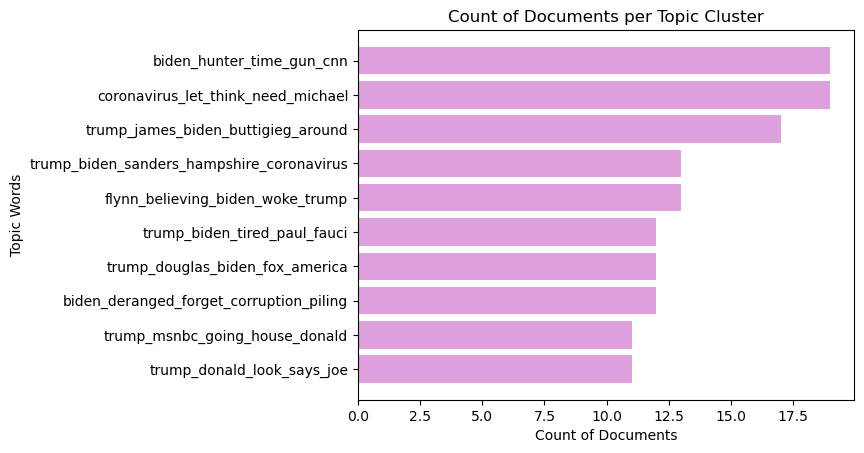

In [113]:
# Create bar plot
plt.barh(top_words, count_docs, color='plum')
plt.xlabel('Count of Documents')
plt.ylabel('Topic Words')
plt.title('Count of Documents per Topic Cluster')
plt.show()

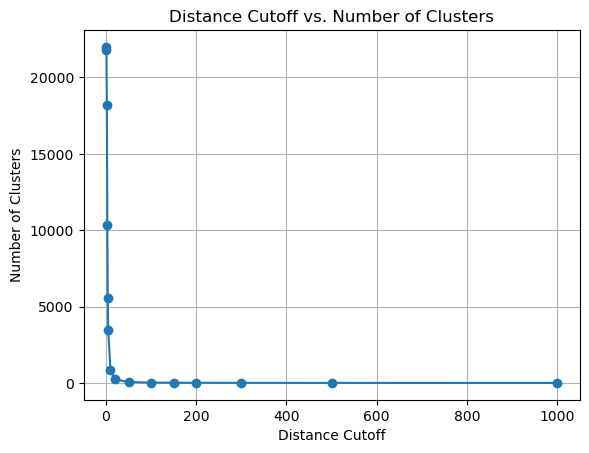

In [101]:
# num_clusters = [18377,18359, 16990, 8711, 4522, 2741, 667, 201, 44, 13, 6, 4]
plt.plot(distance_options, num_clusters, marker='o')
plt.xlabel('Distance Cutoff')
plt.ylabel('Number of Clusters')
plt.title('Distance Cutoff vs. Number of Clusters')
plt.grid(True)
plt.show()

## Disregard this

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [129]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [130]:
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

In [142]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words))

In [163]:
tfidf_scores_by_cluster = {}
cluster_sizes = {}
for clust_id in list(train_cluster_assignments.loc[:, 'cluster_dist_30'].unique()):
    clust_df = train_cluster_assignments.loc[train_cluster_assignments.loc[:, 'cluster_dist_30'] == clust_id, :]
    cluster_sizes[clust_id] = clust_df.shape[0]
    clust_text = clust_df.loc[:, 'title'].values
    tfidf_matrix = tfidf_vectorizer.fit_transform(clust_text)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0)
    tfidf_scores_by_cluster[clust_id] = [(feature_names[col], tfidf_scores[0, col]) for col in tfidf_matrix.nonzero()[1]]

In [165]:
top_words_by_cluster = {}
for cluster_id, scores in tfidf_scores_by_cluster.items():
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    unique_sorted_data = []
    seen_tuples = set()
    for key, value in sorted_scores:
        if value not in seen_tuples:
            unique_sorted_data.append((key, value))
            seen_tuples.add(value)
    top_words_by_cluster[cluster_id] = unique_sorted_data[:10]# sorted_scores[:10]  # Select top N words

In [52]:
# for cluster_id, top_words in top_words_by_cluster.items():
#     print(f"Cluster {cluster_id}:")
#     for word, score in top_words:
#         print(f"- {word}: {score}")

In [171]:
sorted_data = sorted(cluster_sizes.items(), key=lambda x: x[1])

In [182]:
# biggest clusters are 2, 8, 80, 3 & 6
biggest_clusters = [2,8, 80, 3, 6, 90, 18, 1, 85]
for keyval in biggest_clusters:
    print(f'top words for cluster {keyval} with {cluster_sizes[keyval]} articles: \n')
    for val in top_words_by_cluster[keyval]:
        print(val)
    print()
   


top words for cluster 2 with 639 articles: 

('trump', 25.7284713134679)
('biden', 19.76383885229551)
('says', 12.05115917358155)
('coronavirus', 10.708141758813094)
('joe', 9.927892117396981)
('people', 7.2366375454754985)
('pelosi', 6.475133300719187)
('exclusive', 5.884360572975603)
('would', 5.817345581487291)
('gop', 5.796088832978004)

top words for cluster 8 with 569 articles: 

('trump', 20.288617669470007)
('biden', 17.34894579232069)
('says', 13.498243345375089)
('joe', 8.442051172260477)
('election', 8.15707868858702)
('coronavirus', 6.957324534102828)
('democrats', 6.264524400784699)
('donald', 5.937839178885937)
('president', 5.453829186684898)
('harris', 5.084818373097128)

top words for cluster 80 with 520 articles: 

('trump', 22.764460733332424)
('biden', 12.948982348482003)
('coronavirus', 11.844207539251428)
('watch', 8.22118717550551)
('live', 7.296096669221238)
('democrats', 6.604052677037129)
('joe', 6.219501930231752)
('house', 6.160765857230613)
('president', 5.